In [1]:
import parcels
import pooch
import xarray
import cartopy


print(f"{parcels.__version__=}")
print(f"{xarray.__version__=}")
print(f"{cartopy.__version__=}")

parcels.__version__='2.4.2'
xarray.__version__='2023.7.0'
cartopy.__version__='0.21.1'


In [2]:
import pooch
import xarray as xr


url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/season_avg.nc",
    known_hash="sha256:aeb1f4166554484a809cc4eb0bb19d5be28874c7ba35ad8ab25ea0bbac463b6b",
)

ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (m: 138, n: 218, season: 4)
Coordinates:
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    waterlevel  (season, m, n) float64 ...
    velocity_x  (season, m, n) float64 ...
    velocity_y  (season, m, n) float64 ...

In [3]:
# https://github.com/OceanParcels/parcels/issues/1358
    
ds = ds.isel(
    m=slice(1, -1),
    n=slice(1, -1),
)

## Parcels expect the arrays to be in time, lat, lon order.

In [4]:
season = ds.sel({"season": "DJF"}) # 'DJF' 'JJA' 'MAM' 'SON'
season = season.transpose("n", "m")

In [5]:
from parcels import FieldSet


variables = {
    "U": "velocity_x", 
    "V": "velocity_y",
}

dimensions = {
    "U": {
        "lat": "n", #"latitude",
        "lon": "m", #"longitude",
    },
    "V": {
        "lat": "n", #"latitude",
        "lon": "m", #"longitude",
    },
}

fieldset = FieldSet.from_xarray_dataset(season, variables, dimensions)

In [6]:
import numpy as np


# https://github.com/OceanParcels/parcels/issues/1235 ?
x, y = -48.66, -26.89  # Itajaí
# x, y = -48.66, -27  # Sim 1
# x, y = -48.66, -27.1  # Sim 2
# x, y = -48.66, -27.3  # Sim 3
# x, y = -48.66, -27.4  # Sim 4
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

xi = find_nearest(ds["m"], x)
yi = find_nearest(ds["n"], y)

x = ds["m"][xi:xi+100].to_numpy()[()]
y = [ds["n"][yi].to_numpy()[()]] * len(x)

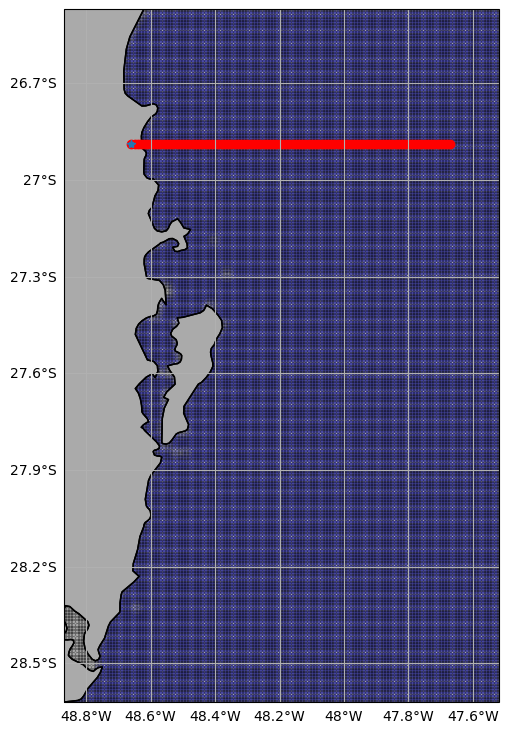

In [7]:
# %matplotlib notebook

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


# Coastline
feature = NaturalEarthFeature(
    name="coastline",
    category="physical",
    scale="10m",
    edgecolor="#000000",
    facecolor="#AAAAAA",
)

bbox = (
    ds["longitude"].min().to_numpy()[()],
    ds["longitude"].max().to_numpy()[()],
    ds["latitude"].min().to_numpy()[()],
    ds["latitude"].max().to_numpy()[()],
)

def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax


# Figure
fig, ax = creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9))
ax.plot(x, y, "ro", zorder=2)
ax.add_feature(feature, zorder=0)
ax.set_extent(bbox)

ax.plot(ds["longitude"], ds["latitude"], color="blue", marker="o", markerfacecolor="none", alpha=0.15, zorder=0);
X, Y = np.meshgrid(ds["m"], ds["n"])
ax.add_feature(feature, zorder=1)
ax.plot(-48.66, -26.89, "*")  # Itajaí
ax.plot(X, Y, "k.", alpha=0.25, zorder=0);

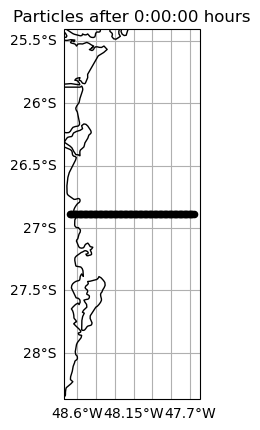

In [8]:
from datetime import timedelta
from parcels import ParticleSet, JITParticle

npart = 10 # nº de particulas liberadas
lon = x# [x] * npart # lon de liberacao das particulas
lat = y# [y] * npart # lat da liberacao das particulas
repeatdt = timedelta(hours=24)

pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lon=lon,
    lat=lat,
    repeatdt=repeatdt,
)


domain = {
    "N": ds["latitude"].max().to_numpy()[()],
    "S": ds["latitude"].min().to_numpy()[()],
    "E": ds["longitude"].max().to_numpy()[()],
    "W": ds["longitude"].min().to_numpy()[()],
}

kw = {"projection": ccrs.PlateCarree()}
pset.show(domain=None, **kw)

In [9]:
from parcels import AdvectionRK4
from parcels.tools.statuscodes import ErrorCode


def DeleteParticle(particle, fieldset, time):
    particle.delete()

    
output_file = pset.ParticleFile(
    name="results-model_tides_and_winds-seasonal.zarr",
    outputdt=timedelta(hours=24)
)

kernels = pset.Kernel(AdvectionRK4)
pset.execute(
    kernels,
    runtime=timedelta(days=10),  # fake days, we don't have the time dim here
    dt=timedelta(hours=1),
    output_file=output_file,
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib1a86e2d2ed59ef6dee3c191337a78d4b_0.so
/home/filipe/micromamba/envs/PARCELS/lib/python3.11/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


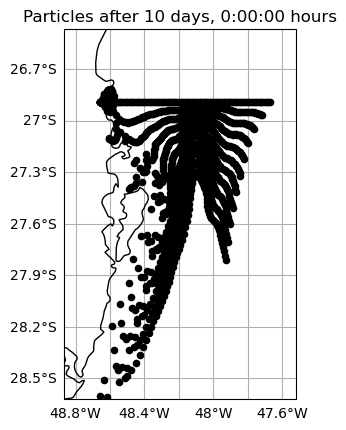

In [10]:
%matplotlib inline
# %matplotlib notebook

pset.show(domain=domain, **kw)

In [11]:
from pathlib import Path

def normalize_speed(u, v):
    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)
    speed = (u**2 + v**2) ** 0.5
    return (u_norm, v_norm, speed)


u = season["velocity_x"].squeeze()
v = season["velocity_y"].squeeze()
u_norm, v_norm, speed = normalize_speed(u, v)

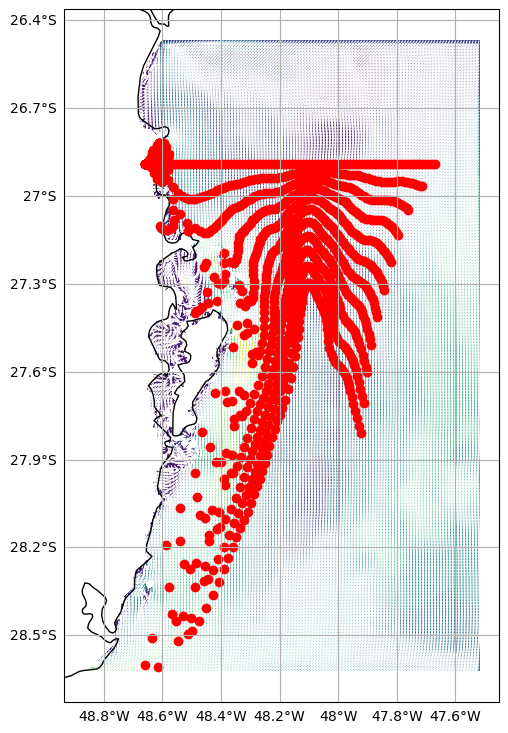

In [12]:
%matplotlib inline
# %matplotlib notebook


fig, ax = creat_map()
masked_speed = np.ma.masked_array(speed, speed.to_numpy() == 0)
ax.contourf(season["longitude"], season["latitude"], masked_speed)
ax.quiver(
    season["longitude"],
    season["latitude"],
    u_norm,
    v_norm,
    color="white",
    scale=50,
)

ax.plot(-48.66, -26.89, "b*", label="Itajaí")

for p in pset:
    ax.plot(p.lon, p.lat, "ro")